## Objective:

This is trying to determine if our current methods will decrease the number of false positives when it comes to dwarf galaxies.

## Method:

An area of the sky will be picked. We want to approximate real world data, so within this area of sky, the number of injected objects will match the numbers according to our corrected counts. These objects will be randomly placed across an area of 9 healpixels of resolution 32, which is what the simple search algorithm needs. As a first test, uniform detection and classification rates will be applie across the entire image. This will be realized many times (100ish?) and simple search will be done. Significances of detections will be recorded. In the second test, non uniform detection and classification rates will be applied. These rates will match closely with our probability assumptions. Only a single bin will be used at first, but in a later stage, having a multi bin approach would be better in terms of matching our approach. In the third test, corrections will be done assuming that the variations in these rates are known.

## Desired Outcome:

The desired outcome is for the first and third tests to return a significance distribution that corresponds to noise, which would have many objects detected at low significance, but then drop off very quickly at higher significances. The second test would hopefully show an extended tail in the high significances.

In [1]:
import ugali
import subprocess
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib
import fitsio
from astropy.table import Table
import healpy as hp
import healsparse as hsp
import skyproj
import IsochroneConfig as isoConfig

Reading fracdet map /hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/fracdet/y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz ...
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = EXPLICIT
Ordering converted to RING


In [2]:
res = isoConfig.res
res = 128
perCovered = isoConfig.perCovered
numMagBins = isoConfig.numMagBins
sigma = isoConfig.sigma
perMap = isoConfig.perMap
perVar = isoConfig.perVar
numBins = isoConfig.numBins
Class_Cutoff = isoConfig.classCutoff
goldCols = isoConfig.goldCols
qualityCuts = isoConfig.qualityCuts

## Test One:

In [3]:
dataPath = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/DwarfGalaxySandboxes/DwarfGalaxySandboxConstantProbsLowRes/'

In [4]:
# countsFile = isoConfig.countsFile

In [5]:
# countsPix = fitsio.read(countsFile)['PIX']
# countsCorr = fitsio.read(countsFile)['CORRECTED']
# fullCounts = np.full(12*(512**2), hp.UNSEEN)
# fullCounts[countsPix] = countsCorr

In [6]:
# Try out 30, -35 for central pixel. "Why this pixel?" you might ask. It came to me in a dream lol.
center_ra, center_dec = 30, -35
proj = ugali.utils.projector.Projector(center_ra, center_dec)

In [7]:
center_pix = hp.ang2pix(32, center_ra, center_dec, lonlat = True, nest = True)

In [8]:
# These are the 9 healpix at 32 resolution simple search would use.
pixels = np.append(hp.pixelfunc.get_all_neighbours(32, center_pix, nest=True), center_pix)
pix32 = np.zeros(12*(32**2))
pix32[pixels] = 1

In [9]:
pix4096 = np.where(hp.ud_grade(pix32, 4096, order_in = 'NESTED', order_out = 'NESTED') > 0)[0]
pix512 = np.where(hp.ud_grade(pix32, 512, order_in = 'NESTED', order_out = 'NESTED') > 0)[0]
pix512Check = np.zeros(12*(512**2))
pix512Check[pix512] = 1
pixRes = np.where(hp.ud_grade(pix32, res, order_in = 'NESTED', order_out = 'NESTED') > 0)[0]
pixResCheck = np.zeros(12*(res**2))
pixResCheck[pixRes] = 1
ra4096, dec4096 = hp.pix2ang(4096, pix4096, lonlat = True, nest = True)
x4096, y4096 = proj.sphereToImage(ra4096, dec4096)
xMax = np.max(x4096) + 0.1
xMin = np.min(x4096) - 0.1
yMax = np.max(y4096) + 0.1
yMin = np.min(y4096) - 0.1

In [10]:
# croppedCounts = fullCounts[pix512]
# sumCount = int(np.round_(np.sum(croppedCounts[np.where(croppedCounts >= 0)[0]]) * len(croppedCounts) / len(np.where(croppedCounts >= 0)[0])))

In [11]:
# # mockPix = np.array([])

# for i in range(1000):
    
#     keepLooping = True
    
#     mockRa = np.array([])
#     mockDec = np.array([])

#     while keepLooping:
#         drawsX = (np.random.rand(100) * (xMax - xMin)) + xMin
#         drawsY = (np.random.rand(100) * (yMax - yMin)) + yMin
#         drawsRa, drawsDec = proj.imageToSphere(drawsX, drawsY)
#         # drawsPix = hp.ang2pix(512, drawsRa, drawsDec, lonlat = True, nest = True)
#         drawsPixCheck = hp.ang2pix(32, drawsRa, drawsDec, lonlat = True, nest = True)
#         # drawsPix = drawsPix[np.where(pix32[drawsPixCheck] > 0)[0]]
#         # mockPix = np.append(mockPix, drawsPix)
#         mockRa = np.append(mockRa, drawsRa[np.where(pix32[drawsPixCheck] > 0)[0]])
#         mockDec = np.append(mockDec, drawsDec[np.where(pix32[drawsPixCheck] > 0)[0]])
#         if len(mockRa) >= sumCount:
#             keepLooping = False
#     mockRa = mockRa[:sumCount]
#     mockDec = mockDec[:sumCount]
    
#     if i == 0:
#         manyMockRa = np.atleast_2d(mockRa)
#         manyMockDec = np.atleast_2d(mockDec)
#     else:
#         manyMockRa = np.append(manyMockRa, np.atleast_2d(mockRa), axis = 0)
#         manyMockDec = np.append(manyMockDec, np.atleast_2d(mockDec), axis = 0)
# # mockPix = mockPix.astype(int)

In [12]:
# pixRepeats = np.sort(mockPix)

# # These are indices that will be looping through the pixStar and starPix arrays in parallel.
# uniqInd = 0
# objInd = 0

# # This will be used to store the number of stars at each pixel.
# objPix = np.unique(pixRepeats) # The unique pixels, with no repeats.
# objDet = np.zeros_like(objPix)

# while objInd < len(pixRepeats):
#     if objPix[uniqInd] == pixRepeats[objInd]: # If the pixels match up in the arrays.
#         objDet[uniqInd] += 1                # Add one for the detection..
#         objInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
#         # Since the last index of pixStar and starPix are the same, starInd will increase the last time through the loop,
#         # making this the index that we must restrict in the while loop.
#     else:
#         uniqInd += 1 # If the pixels are no longer the same, increase the index you check in the pixStar array.

# fullSkyObjects = np.full(12*(512**2), hp.UNSEEN)
# fullSkyObjects[objPix] = objDet

In [13]:
# nside_coverage = 32
# hspCheck = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullSkyObjects)

In [14]:
# # The default DES projection is a McBrydeSkymap.
# fig = plt.figure(1, figsize=(8, 6))
# ax = fig.add_subplot(111)
# sp = skyproj.DESSkyproj(ax=ax)
# sp.draw_hspmap(hspCheck, cmap = 'inferno')
# plt.clim(0, 10)
# plt.colorbar(location = 'bottom')
# plt.show()

In [15]:
testPath = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/DwarfGalaxySandbox/FirstTest/'

In [16]:
# CLASS = 0
# GMAG = 22
# RMAG = 21.8
# IMAG = 20
# ZMAG = 20
# MAG_ERR = 0
# SIZE = 0.01

In [17]:
# for i in np.arange(len(manyMockRa)):
#     my_table = Table()
#     my_table['RA'] = manyMockRa[i]
#     my_table['DEC'] = manyMockDec[i]
#     my_table['EXTENDED_CLASS_SOF'] = np.full(sumCount, CLASS)
#     my_table['SOF_CM_T'] = np.full(sumCount, SIZE)
#     my_table['SOF_PSF_MAG_G'] = np.full(sumCount, GMAG)
#     my_table['SOF_PSF_MAG_R'] = np.full(sumCount, RMAG)
#     my_table['SOF_PSF_MAG_I'] = np.full(sumCount, IMAG)
#     my_table['SOF_PSF_MAG_Z'] = np.full(sumCount, ZMAG)
#     my_table['SOF_PSF_MAG_ERR_G'] = np.full(sumCount, MAG_ERR)
#     my_table['SOF_PSF_MAG_ERR_R'] = np.full(sumCount, MAG_ERR)
#     my_table['SOF_PSF_MAG_ERR_I'] = np.full(sumCount, MAG_ERR)
#     my_table['SOF_PSF_MAG_ERR_Z'] = np.full(sumCount, MAG_ERR)
#     my_table.write(testPath + "True_Star_" + str(i) + ".fits", overwrite = True)

In [18]:
# all_sigs_file = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/DwarfGalaxySandbox/FirstTestSigs.fits'
# all_sigs = fitsio.read(all_sigs_file)['SIGS']

In [19]:
# plt.figure(dpi = 120)
# plt.hist(all_sigs, bins = np.linspace(0, 10, 26))
# plt.yscale('log')
# plt.show()

## Second Test

In [20]:
OGBinsCountFile = isoConfig.OGBinsCountFile
TSBinsCountFile = isoConfig.TSBinsCountFile

In [21]:
OG_Sum_Counts = []
TS_Sum_Counts = []

for i in range(numMagBins):
    countsPix = fitsio.read(TSBinsCountFile)['PIX']
    fullCounts = np.full(12*(512**2), hp.UNSEEN)
    fullCounts[countsPix] = fitsio.read(TSBinsCountFile)[str(i)]
    croppedCounts = fullCounts[pix512]
    TS_Sum_Counts.append(int(np.round_(np.sum(croppedCounts[np.where(croppedCounts >= 0)[0]]) * len(croppedCounts) / len(np.where(croppedCounts >= 0)[0]))))
    
    countsPix = fitsio.read(OGBinsCountFile)['PIX']
    fullCounts = np.full(12*(512**2), hp.UNSEEN)
    fullCounts[countsPix] = fitsio.read(OGBinsCountFile)[str(i)]
    croppedCounts = fullCounts[pix512]
    OG_Sum_Counts.append(int(np.round_(np.sum(croppedCounts[np.where(croppedCounts >= 0)[0]]) * len(croppedCounts) / len(np.where(croppedCounts >= 0)[0]))))

In [22]:
TS_Sum_Counts

[2864, 2804, 2263, 1279, 2432]

In [23]:
# starMockRa = []
# starMockDec = []
# starMockPix = []

# for sumIndex in range(len(TS_Sum_Counts)):

#     for i in range(1000):

#         keepLooping = True

#         mockRa = np.array([])
#         mockDec = np.array([])
#         mockPix = np.array([])

#         while keepLooping:
#             drawsX = (np.random.rand(100) * (xMax - xMin)) + xMin
#             drawsY = (np.random.rand(100) * (yMax - yMin)) + yMin
#             drawsRa, drawsDec = proj.imageToSphere(drawsX, drawsY)
#             drawsPix = hp.ang2pix(res, drawsRa, drawsDec, lonlat = True, nest = True)
#             mockRa = np.append(mockRa, drawsRa[np.where(pixResCheck[drawsPix] > 0)[0]])
#             mockDec = np.append(mockDec, drawsDec[np.where(pixResCheck[drawsPix] > 0)[0]])
#             mockPix = np.append(mockPix, drawsPix[np.where(pixResCheck[drawsPix] > 0)[0]])
#             if len(mockRa) >= TS_Sum_Counts[sumIndex]:
#                 keepLooping = False
#         mockRa = mockRa[:TS_Sum_Counts[sumIndex]]
#         mockDec = mockDec[:TS_Sum_Counts[sumIndex]]
#         mockPix = mockPix[:TS_Sum_Counts[sumIndex]]

#         if i == 0:
#             manyMockRaBin = np.atleast_2d(mockRa)
#             manyMockDecBin = np.atleast_2d(mockDec)
#             manyMockPixBin = np.atleast_2d(mockPix)
#         else:
#             manyMockRaBin = np.append(manyMockRaBin, np.atleast_2d(mockRa), axis = 0)
#             manyMockDecBin = np.append(manyMockDecBin, np.atleast_2d(mockDec), axis = 0)
#             manyMockPixBin = np.append(manyMockPixBin, np.atleast_2d(mockPix), axis = 0)
        
#     starMockRa.append(manyMockRaBin)
#     starMockDec.append(manyMockDecBin)
#     starMockPix.append(manyMockPixBin)

In [24]:
# galaMockRa = []
# galaMockDec = []
# galaMockPix = []

# for sumIndex in range(len(OG_Sum_Counts)):

#     for i in range(1000):

#         keepLooping = True

#         mockRa = np.array([])
#         mockDec = np.array([])
#         mockPix = np.array([])

#         while keepLooping:
#             drawsX = (np.random.rand(100) * (xMax - xMin)) + xMin
#             drawsY = (np.random.rand(100) * (yMax - yMin)) + yMin
#             drawsRa, drawsDec = proj.imageToSphere(drawsX, drawsY)
#             drawsPix = hp.ang2pix(res, drawsRa, drawsDec, lonlat = True, nest = True)
#             mockRa = np.append(mockRa, drawsRa[np.where(pixResCheck[drawsPix] > 0)[0]])
#             mockDec = np.append(mockDec, drawsDec[np.where(pixResCheck[drawsPix] > 0)[0]])
#             mockPix = np.append(mockPix, drawsPix[np.where(pixResCheck[drawsPix] > 0)[0]])
#             if len(mockRa) >= OG_Sum_Counts[sumIndex]:
#                 keepLooping = False
#         mockRa = mockRa[:OG_Sum_Counts[sumIndex]]
#         mockDec = mockDec[:OG_Sum_Counts[sumIndex]]
#         mockPix = mockPix[:OG_Sum_Counts[sumIndex]]

#         if i == 0:
#             manyMockRaBin = np.atleast_2d(mockRa)
#             manyMockDecBin = np.atleast_2d(mockDec)
#             manyMockPixBin = np.atleast_2d(mockPix)
#         else:
#             manyMockRaBin = np.append(manyMockRaBin, np.atleast_2d(mockRa), axis = 0)
#             manyMockDecBin = np.append(manyMockDecBin, np.atleast_2d(mockDec), axis = 0)
#             manyMockPixBin = np.append(manyMockPixBin, np.atleast_2d(mockPix), axis = 0)
        
#     galaMockRa.append(manyMockRaBin)
#     galaMockDec.append(manyMockDecBin)
#     galaMockPix.append(manyMockPixBin)

In [25]:
starDetProbFiles = isoConfig.starDetProbFiles
starProbFiles = isoConfig.starProbFiles
galaProbFiles = isoConfig.galaProbFiles

In [26]:
pixFile = isoConfig.pixFile
validPix = fitsio.read(pixFile)['PIXEL']
pixCheck = np.full(12*(512**2), False, dtype = bool)
pixCheck[validPix] = True

In [27]:
starDetProbs = []
for i in range(len(starDetProbFiles)):
    fullSkyProb = np.full(12*(512**2), np.average(np.clip(fitsio.read(starDetProbFiles[i])['SIGNAL'], 0, 1)))
    # fullSkyProb[validPix] = np.clip(fitsio.read(starDetProbFiles[i])['SIGNAL'], 0, 1)
    fullSkyProb = hp.ud_grade(fullSkyProb, res, order_in = 'NESTED', order_out = 'NESTED')
    starDetProbs.append(fullSkyProb)

starProbs = []
for i in range(len(starProbFiles)):
    fullSkyProb = np.full(12*(512**2), np.average(np.clip(fitsio.read(starProbFiles[i])['SIGNAL'], 0, 1)))
    # fullSkyProb[validPix] = np.clip(fitsio.read(starProbFiles[i])['SIGNAL'], 0, 1)
    fullSkyProb = hp.ud_grade(fullSkyProb, res, order_in = 'NESTED', order_out = 'NESTED')
    starProbs.append(fullSkyProb)

galaProbs = []
for i in range(len(galaProbFiles)):
    fullSkyProb = np.full(12*(512**2), np.average(np.clip(fitsio.read(galaProbFiles[i])['SIGNAL'], 0, 1)))
    # fullSkyProb[validPix] = np.clip(fitsio.read(galaProbFiles[i])['SIGNAL'], 0, 1)
    fullSkyProb = hp.ud_grade(fullSkyProb, res, order_in = 'NESTED', order_out = 'NESTED')
    galaProbs.append(fullSkyProb)

In [28]:
# classifiedStarMockRa = []
# classifiedStarMockDec = []

# classifiedGalaMockRa = []
# classifiedGalaMockDec = []

# for magIndex in np.arange(len(starMockPix)):
    
#     manyMockStarClassRaBin = []
#     manyMockStarClassDecBin = []
    
#     manyMockGalaClassRaBin = []
#     manyMockGalaClassDecBin = []
    
#     for realization in np.arange(len(starMockPix[magIndex])):
#         # Random draws to assign classifications
#         randStarDet = np.random.rand(len(starMockPix[magIndex][realization]))
#         randStarClass = np.random.rand(len(starMockPix[magIndex][realization]))
#         randGalaClass = np.random.rand(len(galaMockPix[magIndex][realization]))
        
#         mockStarRa = starMockRa[magIndex][realization][np.where((randStarDet <= starDetProbs[magIndex][starMockPix[magIndex][realization].astype(int)]) & (randStarClass <= starProbs[magIndex][starMockPix[magIndex][realization].astype(int)]))[0]]
#         mockStarDec = starMockDec[magIndex][realization][np.where((randStarDet <= starDetProbs[magIndex][starMockPix[magIndex][realization].astype(int)]) & (randStarClass <= starProbs[magIndex][starMockPix[magIndex][realization].astype(int)]))[0]]
#         mockStarRa = np.append(mockStarRa, galaMockRa[magIndex][realization][np.where(randGalaClass > galaProbs[magIndex][galaMockPix[magIndex][realization].astype(int)])[0]])
#         mockStarDec = np.append(mockStarDec, galaMockDec[magIndex][realization][np.where(randGalaClass > galaProbs[magIndex][galaMockPix[magIndex][realization].astype(int)])[0]])
        
#         mockGalaRa = starMockRa[magIndex][realization][np.where((randStarDet <= starDetProbs[magIndex][starMockPix[magIndex][realization].astype(int)]) & (randStarClass > starProbs[magIndex][starMockPix[magIndex][realization].astype(int)]))[0]]
#         mockGalaDec = starMockDec[magIndex][realization][np.where((randStarDet <= starDetProbs[magIndex][starMockPix[magIndex][realization].astype(int)]) & (randStarClass > starProbs[magIndex][starMockPix[magIndex][realization].astype(int)]))[0]]
#         mockGalaRa = np.append(mockGalaRa, galaMockRa[magIndex][realization][np.where(randGalaClass <= galaProbs[magIndex][galaMockPix[magIndex][realization].astype(int)])[0]])
#         mockGalaDec = np.append(mockGalaDec, galaMockDec[magIndex][realization][np.where(randGalaClass <= galaProbs[magIndex][galaMockPix[magIndex][realization].astype(int)])[0]])
        
#         manyMockStarClassRaBin.append(mockStarRa)
#         manyMockStarClassDecBin.append(mockStarDec)

#         manyMockGalaClassRaBin.append(mockGalaRa)
#         manyMockGalaClassDecBin.append(mockGalaDec)
    
#     classifiedStarMockRa.append(manyMockStarClassRaBin)
#     classifiedStarMockDec.append(manyMockStarClassDecBin)

#     classifiedGalaMockRa.append(manyMockGalaClassRaBin)
#     classifiedGalaMockDec.append(manyMockGalaClassDecBin)

In [29]:
# secondTestPath = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/DwarfGalaxySandbox/SecondTestStars/'
# secondTestPathGalaxies = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/DwarfGalaxySandbox/SecondTestGalaxies/'
secondTestPath = dataPath + 'SecondTestStars/'
secondTestPathGalaxies = dataPath + 'SecondTestGalaxies/'

firstTestPath = dataPath + 'FirstTest/'

In [30]:
# matStarFile = isoConfig.matStarFile

# matStarRMAG = np.sort(fitsio.read(matStarFile)['RMAG'])

# splitMags = np.array_split(matStarRMAG, numMagBins)

# magBins = [] # This will define the boundary of bins so that the number of objects is constant.
# for i in np.arange(len(splitMags) - 1):
#     magBins.append(splitMags[i][-1])
    
# print(magBins)

In [31]:
CLASS = 0
GMAG = [19.5, 20.5, 22.25, 23.25, 23.75]
RMAG = [19, 20, 22, 23, 23.5]
IMAG = 20
ZMAG = 20
MAG_ERR = 0
SIZE = 0.01

In [32]:
# for realization in np.arange(len(classifiedStarMockRa[0])):
#     my_table = Table()
    
#     RA_store = np.array([])
#     DEC_store = np.array([])
#     GMAG_store = np.array([])
#     RMAG_store = np.array([])
    
#     for magIndex in np.arange(len(classifiedStarMockRa)):
#         RA_store = np.append(RA_store, classifiedStarMockRa[magIndex][realization])
#         DEC_store = np.append(DEC_store, classifiedStarMockDec[magIndex][realization])
#         GMAG_store = np.append(GMAG_store, np.full(len(classifiedStarMockRa[magIndex][realization]), GMAG[magIndex]))
#         RMAG_store = np.append(RMAG_store, np.full(len(classifiedStarMockRa[magIndex][realization]), RMAG[magIndex]))
    
#     my_table['RA'] = RA_store
#     my_table['DEC'] = DEC_store
#     my_table['EXTENDED_CLASS_SOF'] = np.full(len(RA_store), CLASS)
#     my_table['SOF_PSF_MAG_G'] = GMAG_store
#     my_table['SOF_PSF_MAG_R'] = RMAG_store
#     my_table['SOF_PSF_MAG_I'] = np.full(len(RA_store), IMAG)
#     my_table['SOF_PSF_MAG_Z'] = np.full(len(RA_store), ZMAG)
#     my_table['SOF_CM_T'] = np.full(len(RA_store), SIZE)
#     my_table['SOF_PSF_MAG_ERR_G'] = np.full(len(RA_store), MAG_ERR)
#     my_table['SOF_PSF_MAG_ERR_R'] = np.full(len(RA_store), MAG_ERR)
#     my_table['SOF_PSF_MAG_ERR_I'] = np.full(len(RA_store), MAG_ERR)
#     my_table['SOF_PSF_MAG_ERR_Z'] = np.full(len(RA_store), MAG_ERR)
#     my_table.write(secondTestPath + "Classified_Star_" + str(realization) + ".fits", overwrite = True)

In [33]:
# for realization in np.arange(len(classifiedGalaMockRa[0])):
#     my_table = Table()
    
#     RA_store = np.array([])
#     DEC_store = np.array([])
#     RMAG_store = np.array([])
    
#     for magIndex in np.arange(len(classifiedGalaMockRa)):
#         RA_store = np.append(RA_store, classifiedGalaMockRa[magIndex][realization])
#         DEC_store = np.append(DEC_store, classifiedGalaMockDec[magIndex][realization])
#         RMAG_store = np.append(RMAG_store, np.full(len(classifiedGalaMockRa[magIndex][realization]), RMAG[magIndex]))
    
#     my_table['RA'] = RA_store
#     my_table['DEC'] = DEC_store
#     my_table['RMAG'] = RMAG_store
#     my_table.write(secondTestPathGalaxies + "Classified_Galaxy_" + str(realization) + ".fits", overwrite = True)

In [34]:
# for realization in np.arange(len(starMockRa[0])):
#     my_table = Table()
    
#     RA_store = np.array([])
#     DEC_store = np.array([])
#     GMAG_store = np.array([])
#     RMAG_store = np.array([])
    
#     for magIndex in np.arange(len(starMockRa)):
#         RA_store = np.append(RA_store, starMockRa[magIndex][realization])
#         DEC_store = np.append(DEC_store, starMockDec[magIndex][realization])
#         GMAG_store = np.append(GMAG_store, np.full(len(starMockRa[magIndex][realization]), GMAG[magIndex]))
#         RMAG_store = np.append(RMAG_store, np.full(len(starMockRa[magIndex][realization]), RMAG[magIndex]))
    
#     my_table['RA'] = RA_store
#     my_table['DEC'] = DEC_store
#     my_table['EXTENDED_CLASS_SOF'] = np.full(len(RA_store), CLASS)
#     my_table['SOF_PSF_MAG_G'] = GMAG_store
#     my_table['SOF_PSF_MAG_R'] = RMAG_store
#     my_table['SOF_PSF_MAG_I'] = np.full(len(RA_store), IMAG)
#     my_table['SOF_PSF_MAG_Z'] = np.full(len(RA_store), ZMAG)
#     my_table['SOF_CM_T'] = np.full(len(RA_store), SIZE)
#     my_table['SOF_PSF_MAG_ERR_G'] = np.full(len(RA_store), MAG_ERR)
#     my_table['SOF_PSF_MAG_ERR_R'] = np.full(len(RA_store), MAG_ERR)
#     my_table['SOF_PSF_MAG_ERR_I'] = np.full(len(RA_store), MAG_ERR)
#     my_table['SOF_PSF_MAG_ERR_Z'] = np.full(len(RA_store), MAG_ERR)
#     my_table.write(firstTestPath + "True_Star_" + str(realization) + ".fits", overwrite = True)

In [35]:
first_sigs_file = dataPath + 'FirstTestSigs.fits'
first_sigs = fitsio.read(first_sigs_file)['SIGS']

second_sigs_file = dataPath + 'SecondTestSigs.fits'
second_sigs = fitsio.read(second_sigs_file)['SIGS']

In [36]:
# plt.figure(dpi = 120)
# plt.hist(second_sigs, bins = np.linspace(0, 10, 26), alpha = 0.5)
# plt.hist(all_sigs, bins = np.linspace(0, 10, 26), alpha = 0.5)
# plt.yscale('log')
# plt.show()

## Third Test

In [37]:
secondTestStarFiles = listdir(secondTestPath)
secondTestGalaFiles = listdir(secondTestPathGalaxies)

In [38]:
thirdTestPath = dataPath + 'ThirdTest/'

In [39]:
# for i in range(len(secondTestStarFiles)):
#     starData = fitsio.read(secondTestPath + secondTestStarFiles[i], columns = ['RA', 'DEC', 'SOF_PSF_MAG_R'])
#     starRA = starData['RA']
#     starDEC = starData['DEC']
#     starRMAG = starData['SOF_PSF_MAG_R']
#     starPIX = hp.ang2pix(res, starRA, starDEC, lonlat = True, nest = True)
    
#     galaData = fitsio.read(secondTestPathGalaxies + secondTestGalaFiles[i], columns = ['RA', 'DEC', 'RMAG'])
#     galaRA = galaData['RA']
#     galaDEC = galaData['DEC']
#     galaRMAG = galaData['RMAG']
#     galaPIX = hp.ang2pix(res, galaRA, galaDEC, lonlat = True, nest = True)
    
#     starPixBins = []
#     galaPixBins = []
    
#     for j in range(len(RMAG)):
#         starPixBins.append(starPIX[np.where(starRMAG == RMAG[j])[0]])
#         galaPixBins.append(galaPIX[np.where(galaRMAG == RMAG[j])[0]])
        
#     sumOrigStar = []
#     sumRecoStar = []
    
#     for j in range(len(starPixBins)):
#         fullOrigStar = np.zeros(12*(res**2))
#         for pix in starPixBins[j]:
#             fullOrigStar[pix] += 1
#         fullOrigGala = np.zeros(12*(res**2))
#         for pix in galaPixBins[j]:
#             fullOrigGala[pix] += 1
        
#         origStar = fullOrigStar[pixRes]
#         origGala = fullOrigGala[pixRes]
        
#         obsStarRecovered = (((galaProbs[j][pixRes] * origStar) + ((galaProbs[j][pixRes] - 1) * origGala)) / ((starProbs[j][pixRes] + galaProbs[j][pixRes] - 1))).astype(float)
        
#         obsStarRecovered[np.where(obsStarRecovered < 0)[0]] = 0
#         obsStarRecovered[np.where(obsStarRecovered > origStar + origGala)[0]] = origStar[np.where(obsStarRecovered > origStar + origGala)[0]] + origGala[np.where(obsStarRecovered > origStar + origGala)[0]] 
#         trueStarRecovered = obsStarRecovered / starDetProbs[j][pixRes].astype(float)
        
#         sumOrigStar.append(origStar)
#         sumRecoStar.append(trueStarRecovered)
        
#     sumOrigStar = np.sum(sumOrigStar, axis = 0)
#     sumRecoStar = np.sum(sumRecoStar, axis = 0)
#     weights = sumRecoStar / sumOrigStar
    
#     strNum = ''
#     for char in secondTestStarFiles[i]:
#         if char.isdigit():
#             strNum += char
    
#     my_table = Table()
#     my_table['PIX'] = pixRes
#     my_table['CORRECTION'] = weights
#     my_table.write(thirdTestPath + "Weights_" + strNum + ".fits", overwrite = True)

In [40]:
third_sigs_file = dataPath + 'ThirdTestSigs.fits'
third_sigs = fitsio.read(third_sigs_file)['SIGS']

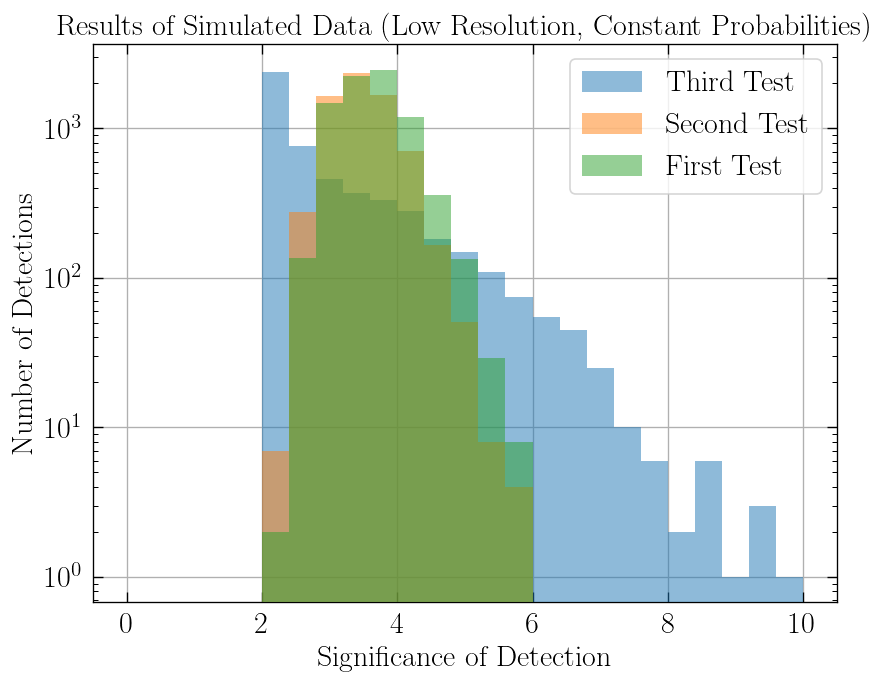

In [41]:
matplotlib.style.use('des_dr1')

plt.figure(dpi = 120)
plt.hist(third_sigs, bins = np.linspace(0, 10, 26), alpha = 0.5, label = 'Third Test', zorder = 3)
plt.hist(second_sigs, bins = np.linspace(0, 10, 26), alpha = 0.5, label = 'Second Test', zorder = 3)
plt.hist(first_sigs, bins = np.linspace(0, 10, 26), alpha = 0.5, label = 'First Test', zorder = 3)
plt.legend()
plt.grid(zorder = 0)
plt.xlabel('Significance of Detection')
plt.ylabel('Number of Detections')
plt.title('Results of Simulated Data (Low Resolution, Constant Probabilities)')
plt.yscale('log')
plt.show()

In [42]:
index = 3
firstTestFile = firstTestPath + listdir(firstTestPath)[index]
secondTestFile = secondTestPath + listdir(secondTestPath)[index]
secondTestGalaxyFile = secondTestPathGalaxies + listdir(secondTestPathGalaxies)[index]
thirdTestFile = thirdTestPath + listdir(thirdTestPath)[index]

In [43]:
firstTestData = fitsio.read(firstTestFile)
secondTestData = fitsio.read(secondTestFile)
secondTestGalaxyData = fitsio.read(secondTestGalaxyFile)
thirdTestData = fitsio.read(thirdTestFile)

In [44]:
firstTestRA = firstTestData['RA']
firstTestDEC = firstTestData['DEC']
firstTestPIX = hp.ang2pix(res, firstTestRA, firstTestDEC, lonlat = True, nest = True)

secondTestRA = secondTestData['RA']
secondTestDEC = secondTestData['DEC']
secondTestPIX = hp.ang2pix(res, secondTestRA, secondTestDEC, lonlat = True, nest = True)

secondTestGalaxyRA = secondTestGalaxyData['RA']
secondTestGalaxyDEC = secondTestGalaxyData['DEC']
secondTestGalaxyPIX = hp.ang2pix(res, secondTestGalaxyRA, secondTestGalaxyDEC, lonlat = True, nest = True)

thirdTestCORRECTION = thirdTestData['CORRECTION']

In [45]:
fullTrueStar = np.full(12*(res**2), hp.UNSEEN)
fullTrueStar[pixRes] = 0
for pix in firstTestPIX:
    fullTrueStar[pix] += 1

fullOrigStar = np.full(12*(res**2), hp.UNSEEN)
fullOrigStar[pixRes] = 0
for pix in secondTestPIX:
    fullOrigStar[pix] += 1
    
fullOrigGala = np.full(12*(res**2), hp.UNSEEN)
fullOrigGala[pixRes] = 0
for pix in secondTestGalaxyPIX:
    fullOrigGala[pix] += 1
    
fullCorrStar = np.full(12*(res**2), hp.UNSEEN)
fullCorrStar[pixRes] = fullOrigStar[pixRes] * thirdTestCORRECTION

In [46]:
nside_coverage = 32
hspTrue = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullTrueStar)
hspOrig = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullOrigStar)
hspCorr = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullCorrStar)
hspGala = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullOrigGala)

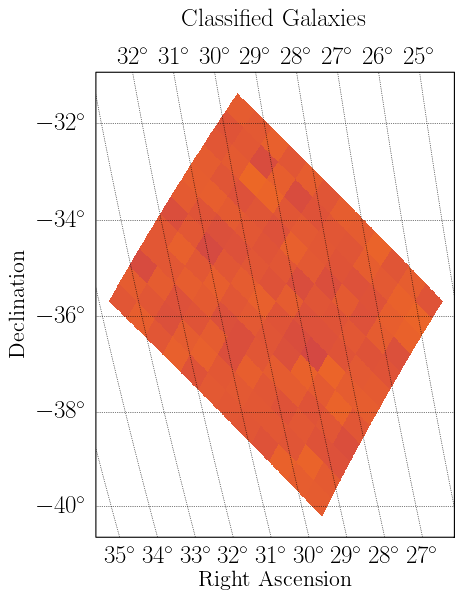

In [72]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspGala, cmap = 'inferno')
plt.clim(0, 2000)
# plt.colorbar(location = 'bottom', shrink = 0.5, label = 'Counts')
plt.title('Classified Galaxies', y = 1.08)
plt.show()

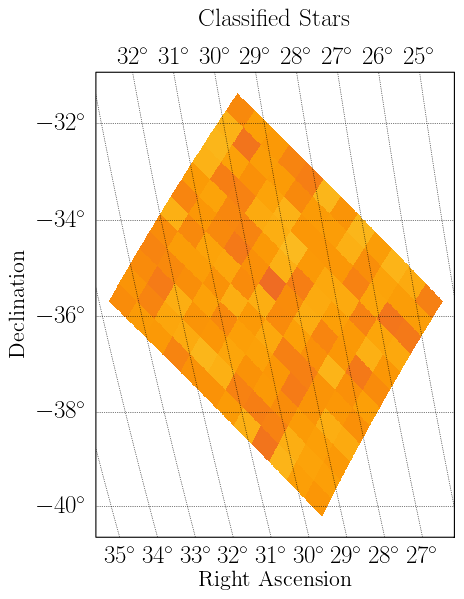

In [95]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspOrig, cmap = 'inferno')
plt.clim(0, 600)
# plt.colorbar(label = 'Counts', orientation = 'vertical')
plt.title('Classified Stars', y = 1.08)
plt.show()

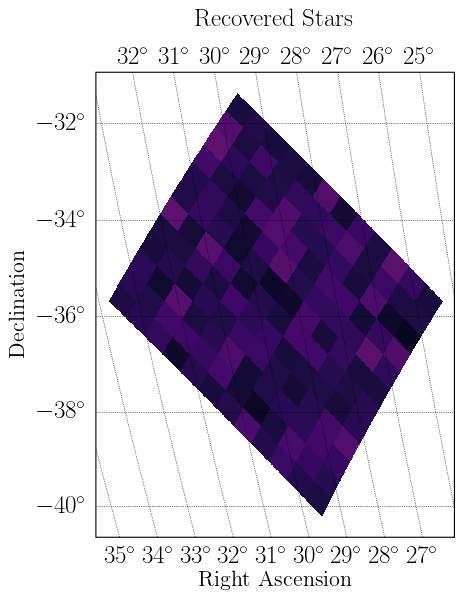

In [96]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspCorr, cmap = 'inferno')
plt.clim(0, 600)
# plt.colorbar(label = 'Counts', orientation = 'vertical')
plt.title('Recovered Stars', y = 1.08)
plt.show()

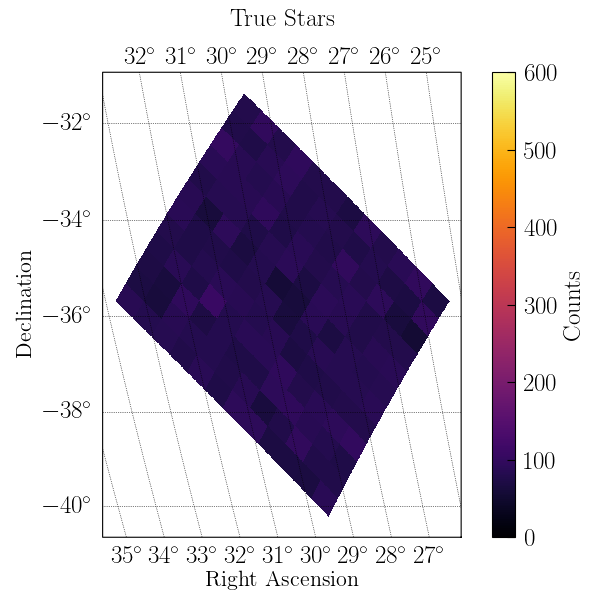

In [97]:
# The default DES projection is a McBrydeSkymap.
fig1 = plt.figure(1, figsize=(8, 6))
ax = fig1.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspTrue, cmap = 'inferno')
plt.clim(0, 600)
plt.colorbar(label = 'Counts', orientation = 'vertical')
plt.title('True Stars', y = 1.08)
plt.show()

# COMBINE THESE PLOTS IN PAINT

In [90]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# fig.suptitle('Stellar Count Comparisons')
# sp1 = skyproj.DESSkyproj(ax=ax1)
# sp1.draw_hspmap(hspOrig, cmap = 'inferno')
# plt.clim(0, 600)
# ax1.set_title('Classified Stars')
# sp2 = skyproj.DESSkyproj(ax=ax2)
# sp2.draw_hspmap(hspCorr, cmap = 'inferno')
# ax2.set_title('Recovered Stars')
# sp3 = skyproj.DESSkyproj(ax=ax3)
# sp3.draw_hspmap(hspTrue, cmap = 'inferno')
# ax3.set_title('True Stars')
# plt.colorbar(label = 'Counts', orientation = 'vertical')

In [51]:
pixToCheck = np.where(fullCorrStar == np.max(fullCorrStar))[0]

In [52]:
print(fullCorrStar[pixToCheck])
print(np.average(fullCorrStar[pixRes]))

[161.71199187]
89.68996077064503


In [53]:
print(fullOrigStar[pixToCheck])
print(np.average(fullOrigStar[pixRes]))

[501.]
463.1041666666667


In [54]:
print(fullOrigGala[pixToCheck])
print(np.average(fullOrigGala[pixRes]))

[1234.]
1237.0902777777778


In [55]:
print(fullTrueStar[pixToCheck])
print(np.average(fullTrueStar[pixRes]))

[101.]
80.84722222222223


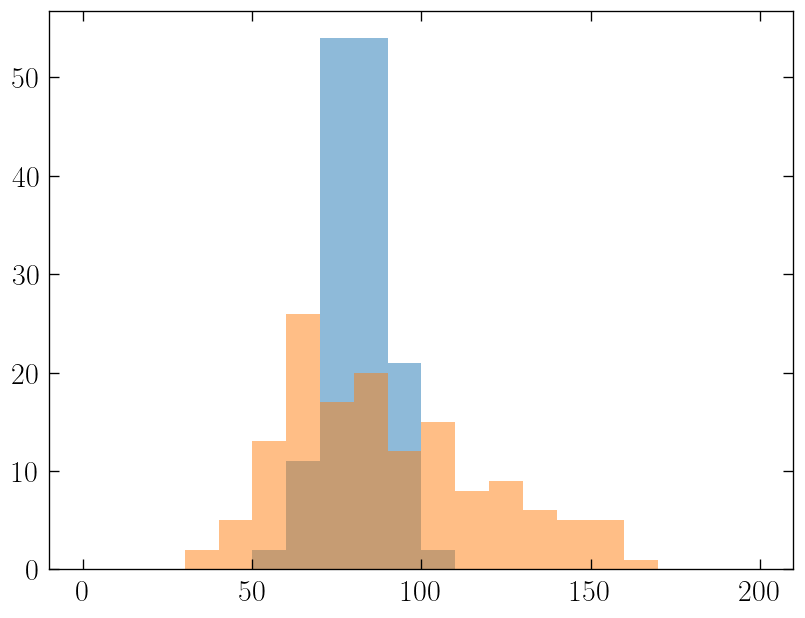

In [56]:
plt.figure(dpi = 120)
plt.hist(fullTrueStar, bins = np.linspace(0, 200, 21), alpha = 0.5)
plt.hist(fullCorrStar, bins = np.linspace(0, 200, 21), alpha = 0.5)
plt.show()